In [1]:
# Common imports
import os
import numpy as np
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, List
from shutil import copyfile

# Data Imports
import pandas as pd
from tqdm import tqdm
from glob import glob
from tensorflow import data as tfd
from tensorflow import image as tfi

# Data Visualization
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls
import PIL

# Model Architecture
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from keras.layers import Dense, Flatten, Dropout, Activation, Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, UpSampling2D, GlobalAveragePooling2D, Reshape, Lambda
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, MobileNetV2, EfficientNetB7, Xception, InceptionResNetV2
from tensorflow.keras.models import load_model

# Model Training
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

# Analysis
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import Callback

import PIL
from pathlib import Path
from PIL import UnidentifiedImageError
import cv2

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#Load Data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
MAIN_IMAGE_PATH = Path("/content/drive/MyDrive/Deep Learning Group Project/segmentation_images/train_val/images/Fish and Vertebrates")
MAIN_MASK_PATH = Path("/content/drive/MyDrive/Deep Learning Group Project/segmentation_images/train_val/masks/Fish and Vertebrates")

OBJECT_PATH = list(MAIN_IMAGE_PATH.glob(r"*.jpg"))
MASK_PATH = list(MAIN_MASK_PATH.glob(r"*.bmp"))

OBJECT_PATH = sorted(OBJECT_PATH)
MASK_PATH = sorted(MASK_PATH)

OBJECT_SERIES = pd.Series(OBJECT_PATH,name="OBJECTS").astype(str)
MASK_SERIES = pd.Series(MASK_PATH,name="MASK").astype(str)

MAIN_DATA = pd.concat([OBJECT_SERIES,MASK_SERIES],axis=1)

MASK_MAIN_TRANSFORMATION = []
OBJECT_MAIN_TRANSFORMATION = []
ADD_MAIN_TRANSFORMATION = []

for x_image,x_mask in zip(MAIN_DATA.OBJECTS,MAIN_DATA.MASK):

    IMAGE_X = cv2.cvtColor(cv2.imread(x_image),cv2.COLOR_BGR2RGB)
    MASK_X = cv2.cvtColor(cv2.imread(x_mask),cv2.COLOR_BGR2RGB)

    RESIZED_X_IMAGE = cv2.resize(IMAGE_X,(300,300))
    RESIZED_X_MASK = cv2.resize(MASK_X,(300,300))

    ADD_X = cv2.addWeighted(RESIZED_X_IMAGE,0.6,RESIZED_X_MASK,0.6,0.5)

    RESIZED_X_ADD = cv2.resize(ADD_X,(300,300))

    MASK_MAIN_TRANSFORMATION.append(RESIZED_X_MASK)
    OBJECT_MAIN_TRANSFORMATION.append(RESIZED_X_IMAGE)
    ADD_MAIN_TRANSFORMATION.append(RESIZED_X_ADD)

print("WHEN IT IS ARRAY IMAGE SHAPE: ",np.shape(np.array(OBJECT_MAIN_TRANSFORMATION)))
print("WHEN IT IS ARRAY MASK SHAPE: ",np.shape(np.array(MASK_MAIN_TRANSFORMATION)))
print("WHEN IT IS ARRAY ADD SHAPE: ",np.shape(np.array(ADD_MAIN_TRANSFORMATION)))

Transformation_Image = np.array(OBJECT_MAIN_TRANSFORMATION,dtype="float32")
Transformation_Mask = np.array(MASK_MAIN_TRANSFORMATION,dtype="float32")
Transformation_Add = np.array(ADD_MAIN_TRANSFORMATION,dtype="float32")

Transformation_Image = Transformation_Image / 255.
Transformation_Mask = Transformation_Mask / 255.
Transformation_Add = Transformation_Add / 255.

print("TRAIN: ",Transformation_Image.shape)
print("TRANSFORMATION MASK: ",Transformation_Mask.shape)
print("TRANSFORMATION ADD: ",Transformation_Add.shape)

WHEN IT IS ARRAY IMAGE SHAPE:  (989, 300, 300, 3)
WHEN IT IS ARRAY MASK SHAPE:  (989, 300, 300, 3)
WHEN IT IS ARRAY ADD SHAPE:  (989, 300, 300, 3)
TRAIN:  (989, 300, 300, 3)
TRANSFORMATION MASK:  (989, 300, 300, 3)
TRANSFORMATION ADD:  (989, 300, 300, 3)


In [5]:
# Constants
input_shape = (300, 300, 3)
BATCH_SIZE = 256 # number of samples per gradient update
EPOCHS = 30 # number of epochs to train the model
NUM_CLASSES = 23 # number of classes at the dataset
SPLIT_SIZE = .8 # Define proportion of images used for training

# Model training
LOSS = 'sparse_categorical_crossentropy'
METRICS = ['accuracy']

# Hyperparameters
LEARNING_RATE = 1e-3 # learning rate for the optimizer

# Random Seed
RANDOM_SEED = 48 # set random seed for reproducibility
os.environ['PYTHONHASHSEED']=str(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED) # set random seed for TensorFlow
np.random.seed(RANDOM_SEED) # set random seed for NumPy
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [6]:
def SegmentationCNN(input_shape):
    # Load pre-trained InceptionV3 model (without top layers)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add custom layers for segmentation
    x = base_model.output
    x = Conv2D(512, (1, 1), activation='relu')(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # Upsample
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # Upsample
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)   # Upsample
    output = Conv2D(3, (1, 1), activation='sigmoid')(x)  # Adjust output channels to match number of classes

    # Crop or pad the output to match the target shape (300, 300, 3)
    target_shape = (300, 300, 3)
    output = Lambda(lambda image: tf.image.resize(image, target_shape[:2]))(output)

    # Create model
    model = Model(inputs=base_model.input, outputs=output)
    return model

In [7]:
model = SegmentationCNN(input_shape)

87910968/87910968 [==============================] - 5s 0us/step


In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
print("Shape of model output:", model.output_shape)
print("Shape of target data:", Transformation_Mask.shape)

Shape of model output: (None, 300, 300, 3)
Shape of target data: (989, 300, 300, 3)


In [10]:
model.fit(Transformation_Image, Transformation_Mask, batch_size=32, epochs=5, validation_split=0.2)

Epoch 1/5
25/25 [==============================] - 88s 1s/step - loss: 0.5422 - accuracy: 0.9176 - val_loss: 1.4003 - val_accuracy: 0.9499
Epoch 2/5
25/25 [==============================] - 13s 522ms/step - loss: 0.4780 - accuracy: 0.9386 - val_loss: 0.6424 - val_accuracy: 0.9473
Epoch 3/5
25/25 [==============================] - 13s 528ms/step - loss: 0.3680 - accuracy: 0.9511 - val_loss: 1.0735 - val_accuracy: 0.9453
Epoch 4/5
25/25 [==============================] - 13s 533ms/step - loss: 0.3092 - accuracy: 0.9172 - val_loss: 0.5877 - val_accuracy: 0.7408
Epoch 5/5
25/25 [==============================] - 13s 535ms/step - loss: 0.2898 - accuracy: 0.8647 - val_loss: 0.5727 - val_accuracy: 0.8810


In [11]:
def show_segmented_images(model, images):
    for image in images:
        # Perform segmentation
        segmented_image = model.predict(np.expand_dims(image, axis=0))

        # Plot original and segmented images
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(segmented_image[0])
        plt.title('Segmented Image')
        plt.axis('off')

        plt.show()

1/1 [==============================] - 3s 3s/step


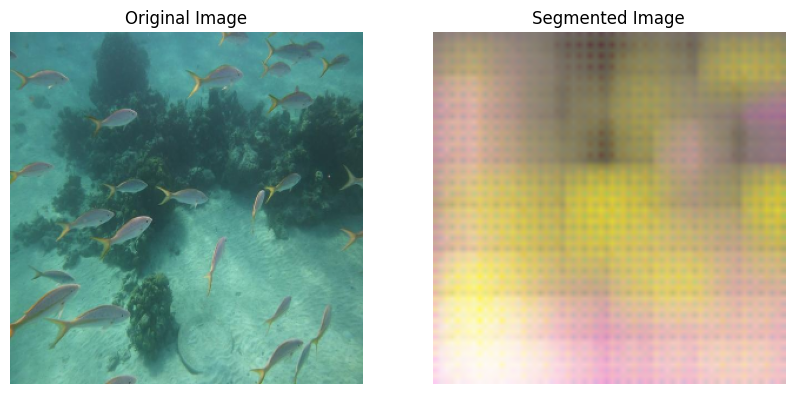

1/1 [==============================] - 0s 39ms/step


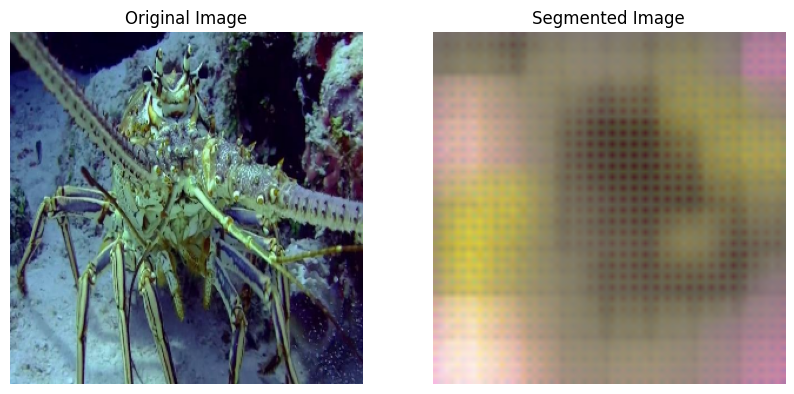

1/1 [==============================] - 0s 44ms/step


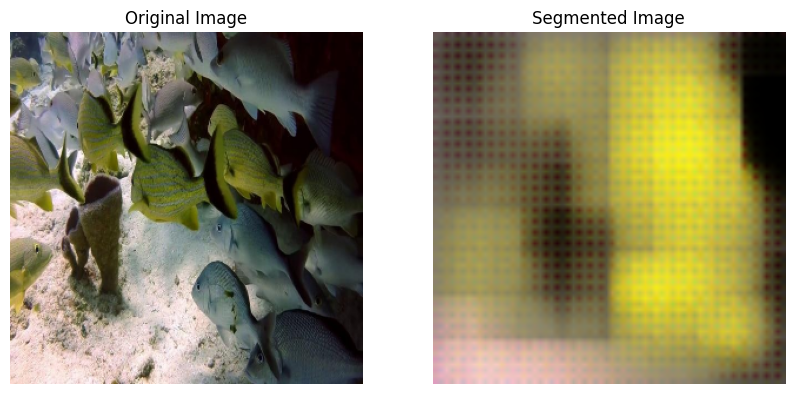

1/1 [==============================] - 0s 45ms/step


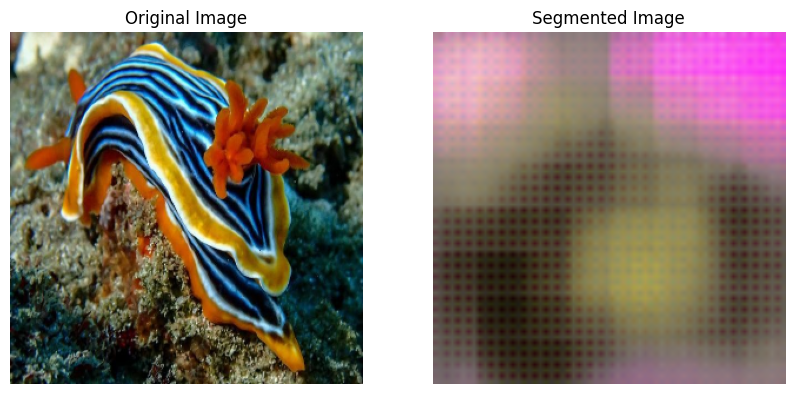

1/1 [==============================] - 0s 41ms/step


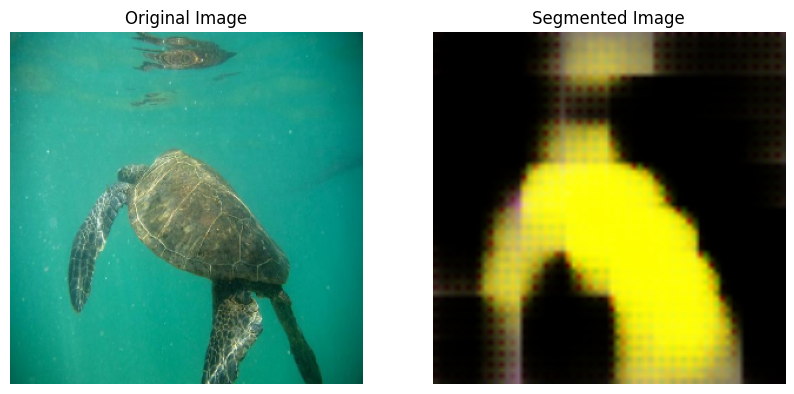

In [12]:
show_segmented_images(model, Transformation_Image[:5])

In [ ]:
def ClassificationCNN(segmentation_model, num_classes=9):
    # Remove the last layer from the segmentation model, because the last layer is used for segmentation, but we don't need that to run our original dataset
    segmentation_output = segmentation_model.layers[-1].output  # Assuming the last layer is the final convolutional layer

    # Global average pooling to reduce dimensions
    pooling = GlobalAveragePooling2D()(segmentation_output)

    # Classification layer
    output = Dense(num_classes, activation='softmax')(pooling)

    # Create model
    model = Model(inputs=segmentation_model.input, outputs=output)
    return model

Using the transfer learning model on our origial dataset

In [ ]:
ORIGINAL_TRAIN_DIR = "/content/drive/MyDrive/Deep Learning Group Project/original_data/train"
ORIGINAL_TEST_DIR = "/content/drive/MyDrive/Deep Learning Group Project/original_data/test"

In [ ]:
# Specify the directory paths for the data (train , test , validate)
# Define root directory
root_dir = '/content/drive/MyDrive/Deep Learning Group Project/images/'
TRAINING_DIR =f"{root_dir}train/"  # path to the directory containing train  data
VALIDATION_DIR = f"{root_dir}valid/" # path to the directory containing validation data
TEST_DIR = f"{root_dir}test/" # path to the directory containing test data

try:
    os.mkdir(root_dir)
    os.mkdir(TRAINING_DIR)
    os.mkdir(VALIDATION_DIR)
    os.mkdir(TEST_DIR)
except FileExistsError:
    print("Dir Already Exists")

Dir Already Exists


In [ ]:
#  create_train_val_dirs
def create_train_val_dirs(root_path):

  os.mkdir(root_path)
  os.mkdir(root_path+'/train')
  os.mkdir(root_path+'/val')
  os.mkdir(root_path+'/train/Fish')
  os.mkdir(root_path+'/train/Goldfish')
  os.mkdir(root_path+'/train/Harbor seal')
  os.mkdir(root_path+'/train/Jellyfish')
  os.mkdir(root_path+'/train/Lobster')
  os.mkdir(root_path+'/train/Oyster')
  os.mkdir(root_path+'/train/Sea turtle')
  os.mkdir(root_path+'/train/Squid')
  os.mkdir(root_path+'/train/Starfish')

  os.mkdir(root_path+'/val/Fish')
  os.mkdir(root_path+'/val/Goldfish')
  os.mkdir(root_path+'/val/Harbor seal')
  os.mkdir(root_path+'/val/Jellyfish')
  os.mkdir(root_path+'/val/Lobster')
  os.mkdir(root_path+'/val/Oyster')
  os.mkdir(root_path+'/val/Sea turtle')
  os.mkdir(root_path+'/val/Squid')
  os.mkdir(root_path+'/val/Starfish')

In [ ]:
# Call create_train_val_dirs

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)
try:
    create_train_val_dirs(root_path=root_dir)
except FileExistsError:
    print("Error")

In [ ]:
# Test your create_train_val_dirs function
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/content/drive/MyDrive/Deep Learning Group Project/images/train
/content/drive/MyDrive/Deep Learning Group Project/images/val
/content/drive/MyDrive/Deep Learning Group Project/images/train/Fish
/content/drive/MyDrive/Deep Learning Group Project/images/train/Goldfish
/content/drive/MyDrive/Deep Learning Group Project/images/train/Harbor seal
/content/drive/MyDrive/Deep Learning Group Project/images/train/Jellyfish
/content/drive/MyDrive/Deep Learning Group Project/images/train/Lobster
/content/drive/MyDrive/Deep Learning Group Project/images/train/Oyster
/content/drive/MyDrive/Deep Learning Group Project/images/train/Sea turtle
/content/drive/MyDrive/Deep Learning Group Project/images/train/Squid
/content/drive/MyDrive/Deep Learning Group Project/images/train/Starfish
/content/drive/MyDrive/Deep Learning Group Project/images/val/Fish
/content/drive/MyDrive/Deep Learning Group Project/images/val/Goldfish
/content/drive/MyDrive/Deep Learning Group Project/images/val/Harbor seal
/content/

In [ ]:
# split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets

  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training

  Returns:
    None
  """

  files = []
  for filename in os.listdir(SOURCE_DIR):
      file = SOURCE_DIR + filename
      if os.path.getsize(file) > 0:
          files.append(filename)
      else:
          print(filename + " is zero length, so ignoring.")

  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]

  for filename in training_set:
      this_file = SOURCE_DIR + filename
      destination = TRAINING_DIR + filename
      copyfile(this_file, destination)

  for filename in testing_set:
      this_file = SOURCE_DIR + filename
      destination = VALIDATION_DIR + filename
      copyfile(this_file, destination)

In [ ]:
# Test your split_data function
# Define paths


Fish_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Fish/"
Goldfish_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Goldfish/"
Harbor_seal_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Harbor seal/"
Jellyfish_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Jellyfish/"
Lobster_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Lobster/"
Oyster_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Oyster/"
Sea_turtle_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Sea turtle/"
Squid_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Squid/"
Starfish_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Starfish/"


TRAINING_DIR = "/content/drive/MyDrive/Deep Learning Group Project/images/train/"
VALIDATION_DIR = "/content/drive/MyDrive/Deep Learning Group Project/images/val/"
TRAINING_Fish_DIR = os.path.join(TRAINING_DIR, "Fish/")
VALIDATION_Fish_DIR = os.path.join(VALIDATION_DIR, "Fish/")
TRAINING_Goldfish_DIR = os.path.join(TRAINING_DIR, "Goldfish/")
VALIDATION_Goldfish_DIR = os.path.join(VALIDATION_DIR, "Goldfish/")
TRAINING_Harbor_seal_DIR = os.path.join(TRAINING_DIR, "Harbor seal/")
VALIDATION_Harbor_seal_DIR = os.path.join(VALIDATION_DIR, "Harbor seal/")
TRAINING_Jellyfish_DIR = os.path.join(TRAINING_DIR, "Jellyfish/")
VALIDATION_Jellyfish_DIR = os.path.join(VALIDATION_DIR, "Jellyfish/")
TRAINING_Lobster_DIR = os.path.join(TRAINING_DIR, "Lobster/")
VALIDATION_Lobster_DIR = os.path.join(VALIDATION_DIR, "Lobster/")
TRAINING_Oyster_DIR = os.path.join(TRAINING_DIR, "Oyster/")
VALIDATION_Oyster_DIR = os.path.join(VALIDATION_DIR, "Oyster/")
TRAINING_Sea_turtle_DIR = os.path.join(TRAINING_DIR, "Sea turtle/")
VALIDATION_Sea_turtle_DIR = os.path.join(VALIDATION_DIR, "Sea turtle/")
TRAINING_Squid_DIR = os.path.join(TRAINING_DIR, "Squid/")
VALIDATION_Squid_DIR = os.path.join(VALIDATION_DIR, "Squid/")
TRAINING_Starfish_DIR = os.path.join(TRAINING_DIR, "Starfish/")
VALIDATION_Starfish_DIR = os.path.join(VALIDATION_DIR, "Starfish/")

# Empty directories in case you run this cell multiple times

if len(os.listdir(TRAINING_Fish_DIR)) > 0:
  for file in os.scandir(TRAINING_Fish_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_Goldfish_DIR)) > 0:
  for file in os.scandir(TRAINING_Goldfish_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_Harbor_seal_DIR)) > 0:
  for file in os.scandir(TRAINING_Harbor_seal_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_Jellyfish_DIR)) > 0:
  for file in os.scandir(TRAINING_Jellyfish_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_Lobster_DIR)) > 0:
  for file in os.scandir(TRAINING_Lobster_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_Oyster_DIR)) > 0:
  for file in os.scandir(TRAINING_Oyster_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_Sea_turtle_DIR)) > 0:
  for file in os.scandir(TRAINING_Sea_turtle_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_Squid_DIR)) > 0:
  for file in os.scandir(TRAINING_Squid_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_Starfish_DIR)) > 0:
  for file in os.scandir(TRAINING_Starfish_DIR):
    os.remove(file.path)

# Validation Dirs

if len(os.listdir(VALIDATION_Fish_DIR)) > 0:
  for file in os.scandir(VALIDATION_Fish_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_Goldfish_DIR)) > 0:
  for file in os.scandir(VALIDATION_Goldfish_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_Harbor_seal_DIR)) > 0:
  for file in os.scandir(VALIDATION_Harbor_seal_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_Jellyfish_DIR)) > 0:
  for file in os.scandir(VALIDATION_Jellyfish_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_Lobster_DIR)) > 0:
  for file in os.scandir(VALIDATION_Lobster_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_Oyster_DIR)) > 0:
  for file in os.scandir(VALIDATION_Oyster_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_Sea_turtle_DIR)) > 0:
  for file in os.scandir(VALIDATION_Sea_turtle_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_Squid_DIR)) > 0:
  for file in os.scandir(VALIDATION_Squid_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_Starfish_DIR)) > 0:
  for file in os.scandir(VALIDATION_Starfish_DIR):
    os.remove(file.path)



# Run the function
split_data(Fish_SOURCE_DIR, TRAINING_Fish_DIR, VALIDATION_Fish_DIR, SPLIT_SIZE)
print(Fish_SOURCE_DIR)
print(TRAINING_Fish_DIR)
print(VALIDATION_Fish_DIR)
split_data(Goldfish_SOURCE_DIR , TRAINING_Goldfish_DIR, VALIDATION_Goldfish_DIR, SPLIT_SIZE)
split_data(Harbor_seal_SOURCE_DIR , TRAINING_Harbor_seal_DIR , VALIDATION_Harbor_seal_DIR, SPLIT_SIZE)
split_data(Jellyfish_SOURCE_DIR, TRAINING_Jellyfish_DIR, VALIDATION_Jellyfish_DIR, SPLIT_SIZE)
split_data(Lobster_SOURCE_DIR, TRAINING_Lobster_DIR, VALIDATION_Lobster_DIR, SPLIT_SIZE)
split_data(Oyster_SOURCE_DIR, TRAINING_Oyster_DIR, VALIDATION_Oyster_DIR, SPLIT_SIZE)
split_data(Sea_turtle_SOURCE_DIR, TRAINING_Sea_turtle_DIR, VALIDATION_Sea_turtle_DIR, SPLIT_SIZE)
split_data(Squid_SOURCE_DIR, TRAINING_Squid_DIR, VALIDATION_Squid_DIR, SPLIT_SIZE)
split_data(Starfish_SOURCE_DIR, TRAINING_Starfish_DIR, VALIDATION_Starfish_DIR, SPLIT_SIZE)



# Check that the number of images matches the expected output
# function should perform copies rather than moving images so original directories should contain unchanged images

# Training and validation splits
num_fish = len(os.listdir(Fish_SOURCE_DIR))
print(f"Original Fish's directory has {num_fish} images")
print(f"There are {len(os.listdir(TRAINING_Fish_DIR))} images of Fish for training")
print(f"There are {len(os.listdir(VALIDATION_Fish_DIR))} images of Fish for validation")
print('\n\n')

num_goldfish = len(os.listdir(Goldfish_SOURCE_DIR))
print(f"Original Goldfish's directory has {num_goldfish} images")
print(f"There are {len(os.listdir(TRAINING_Goldfish_DIR))} images of Goldfish for training")
print(f"There are {len(os.listdir(VALIDATION_Goldfish_DIR))} images of Goldfish for validation")
print('\n\n')

num_seal = len(os.listdir(Harbor_seal_SOURCE_DIR))
print(f"Original Harbor seal's directory has {num_seal} images")
print(f"There are {len(os.listdir(TRAINING_Harbor_seal_DIR))} images of Harbor seal for training")
print(f"There are {len(os.listdir(VALIDATION_Harbor_seal_DIR))} images of Harbor seal for validation")
print('\n\n')

num_jellyfish = len(os.listdir(Jellyfish_SOURCE_DIR))
print(f"Original Jellyfish's directory has {num_jellyfish} images")
print(f"There are {len(os.listdir(TRAINING_Jellyfish_DIR))} images of Jellyfish for training")
print(f"There are {len(os.listdir(VALIDATION_Jellyfish_DIR))} images of Jellyfish for validation")
print('\n\n')

num_lobster = len(os.listdir(Lobster_SOURCE_DIR))
print(f"Original Lobster's directory has {num_lobster} images")
print(f"There are {len(os.listdir(TRAINING_Lobster_DIR))} images of Lobster for training")
print(f"There are {len(os.listdir(VALIDATION_Lobster_DIR))} images of Lobster for validation")
print('\n\n')

num_oyster = len(os.listdir(Oyster_SOURCE_DIR))
print(f"Original Oyster's directory has {num_oyster} images")
print(f"There are {len(os.listdir(TRAINING_Oyster_DIR))} images of Oyster for training")
print(f"There are {len(os.listdir(VALIDATION_Oyster_DIR))} images of Oyster for validation")
print('\n\n')

num_turtle = len(os.listdir(Sea_turtle_SOURCE_DIR))
print(f"Original Sea turtle's directory has {num_turtle} images")
print(f"There are {len(os.listdir(TRAINING_Sea_turtle_DIR))} images of Sea turtle for training")
print(f"There are {len(os.listdir(VALIDATION_Sea_turtle_DIR))} images of Sea turtle for validation")
print('\n\n')

num_squid = len(os.listdir(Squid_SOURCE_DIR))
print(f"Original Squid's directory has {num_squid} images")
print(f"There are {len(os.listdir(TRAINING_Squid_DIR))} images of Squid for training")
print(f"There are {len(os.listdir(VALIDATION_Squid_DIR))} images of Squid for validation")
print('\n\n')

num_starfish = len(os.listdir(Starfish_SOURCE_DIR))
print(f"Original Starfish's directory has {num_starfish} images")
print(f"There are {len(os.listdir(TRAINING_Starfish_DIR))} images of Starfish for training")
print(f"There are {len(os.listdir(VALIDATION_Starfish_DIR))} images of Starfish for validation")
print('\n\n')

/content/drive/MyDrive/Deep Learning Group Project/original_data/train/Fish/
/content/drive/MyDrive/Deep Learning Group Project/images/train/Fish/
/content/drive/MyDrive/Deep Learning Group Project/images/val/Fish/
Original Fish's directory has 89 images
There are 71 images of Fish for training
There are 18 images of Fish for validation



Original Goldfish's directory has 65 images
There are 52 images of Goldfish for training
There are 13 images of Goldfish for validation



Original Harbor seal's directory has 46 images
There are 36 images of Harbor seal for training
There are 10 images of Harbor seal for validation



Original Jellyfish's directory has 85 images
There are 68 images of Jellyfish for training
There are 17 images of Jellyfish for validation



Original Lobster's directory has 39 images
There are 31 images of Lobster for training
There are 8 images of Lobster for validation



Original Oyster's directory has 62 images
There are 49 images of Oyster for training
There are

In [ ]:
IMAGE_SIZE = 160 # size of the input image

#  train_val_generators
# data preprocessing
def train_val_generators(TRAINING_DIR, VALIDATION_DIR , TEST_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale=1./255.)  # Rescale pixel values to be between 0 and 1

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                      shuffle = True)

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale=1.0/255.) #set the rescale argument

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=BATCH_SIZE,
                                                                class_mode='categorical',
                                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                shuffle = True)

  # Instantiate the ImageDataGenerator class  , For test datagenerator, we only normalize the data.
  test_datagen = ImageDataGenerator(rescale=1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE))

  return train_generator, validation_generator, test_generator

In [ ]:
train_generator, validation_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, ORIGINAL_TEST_DIR)

Found 494 images belonging to 9 classes.
Found 127 images belonging to 9 classes.
Found 185 images belonging to 9 classes.


In [ ]:
# Create X_train and y_train from the train_generator
X_train, y_train = next(train_generator)

# Create X_test and y_test from the test_generator
X_test, y_test = next(test_generator)

In [ ]:
input_shape_classification = X_train.shape[1:]
input_shape_classification

(160, 160, 3)

In [ ]:
pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


In [ ]:
from keras_tuner import HyperModel

class ClassificationHyperModel(HyperModel):
    def __init__(self, base_model):
        self.base_model = base_model

    def build(self, hp):
        # Hyperparameters to tune
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        dense_units = hp.Int('dense_units', min_value=32, max_value=512, step=32)

        # Build model
        base_model = self.base_model
        base_model.trainable = False  # Freeze the base model

        # Adding custom layers
        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(dense_units, activation='relu')(x)
        outputs = Dense(9, activation='softmax')(x)  # Adjust number of classes if necessary

        model = Model(inputs=base_model.input, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

In [ ]:
from keras_tuner import RandomSearch

# Assume 'model' is your pre-loaded base model
hypermodel = ClassificationHyperModel(base_model=model)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,  # Number of variations on hyperparameters
    executions_per_trial=2,  # Number of models that should be built and fit for each trial
    directory='my_dir',  # Directory to save logs and models
    project_name='classification_tuning'
)

tuner.search(train_generator,
             epochs=10,
             validation_data=validation_generator)

best_model = tuner.get_best_models(num_models=1)[0]

Trial 9 Complete [00h 03m 12s]
val_accuracy: 0.17716535925865173

Best val_accuracy So Far: 0.23228346556425095
Total elapsed time: 00h 30m 05s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
0.001             |0.01              |learning_rate
96                |512               |dense_units

Epoch 1/10
2/2 [==============================] - 17s 9s/step - loss: 2.1971 - accuracy: 0.1113 - val_loss: 2.1860 - val_accuracy: 0.1654
Epoch 2/10
2/2 [==============================] - 7s 4s/step - loss: 2.1917 - accuracy: 0.1660 - val_loss: 2.1825 - val_accuracy: 0.1654
Epoch 3/10
2/2 [==============================] - 8s 5s/step - loss: 2.1871 - accuracy: 0.1478 - val_loss: 2.1791 - val_accuracy: 0.1890
Epoch 4/10
2/2 [==============================] - 7s 4s/step - loss: 2.1825 - accuracy: 0.1721 - val_loss: 2.1757 - val_accuracy: 0.1811
Epoch 5/10
2/2 [==============================] - 8s 4s/step - loss: 2.1777 - accuracy: 0.1802 - val_loss: 2.1725 - val_acc

In [ ]:
# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_learning_rate = 0.01
best_dropout_rate = 0.2

In [ ]:
# Create the ClassificationCNN model
classification_model = ClassificationCNN(model)

In [ ]:
classification_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
optimizer = Adam(learning_rate=best_learning_rate)

In [ ]:
classification_model.fit(train_generator, epochs=30)

Epoch 1/30
2/2 [==============================] - 52s 9s/step - loss: 2.1960 - accuracy: 0.1255
Epoch 2/30
2/2 [==============================] - 6s 3s/step - loss: 2.1138 - accuracy: 0.1417
Epoch 3/30
2/2 [==============================] - 6s 3s/step - loss: 2.0621 - accuracy: 0.1680
Epoch 4/30
2/2 [==============================] - 6s 3s/step - loss: 2.0209 - accuracy: 0.2146
Epoch 5/30
2/2 [==============================] - 6s 3s/step - loss: 1.9832 - accuracy: 0.2713
Epoch 6/30
2/2 [==============================] - 6s 3s/step - loss: 1.9671 - accuracy: 0.3036
Epoch 7/30
2/2 [==============================] - 6s 3s/step - loss: 1.9560 - accuracy: 0.3239
Epoch 8/30
2/2 [==============================] - 6s 2s/step - loss: 1.9395 - accuracy: 0.3360
Epoch 9/30
2/2 [==============================] - 6s 3s/step - loss: 1.9203 - accuracy: 0.3684
Epoch 10/30
2/2 [==============================] - 6s 3s/step - loss: 1.9176 - accuracy: 0.3441
Epoch 11/30
2/2 [==============================]

In [ ]:
test_loss, test_accuracy = classification_model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

1/1 [==============================] - 6s 6s/step - loss: 2.2621 - accuracy: 0.2054
Test Loss: 2.2621
Test Accuracy: 0.2054


In [ ]:
predicted_labels = classification_model.predict(test_generator)
predicted_labels = np.argmax(predicted_labels, axis=1)

true_labels = test_generator.classes

conf_matrix = confusion_matrix(true_labels, predicted_labels)

1/1 [==============================] - 3s 3s/step


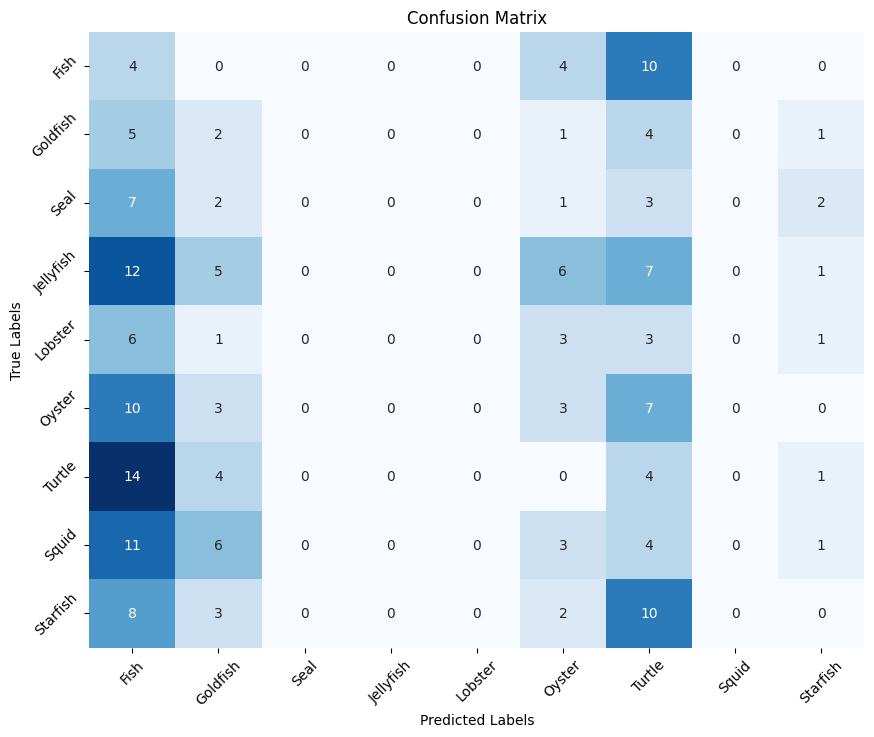

In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

labels = ['Fish', 'Goldfish', 'Seal', 'Jellyfish', 'Lobster', 'Oyster', 'Turtle', 'Squid', 'Starfish']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

Epoch 1/30
2/2 [==============================] - 10s 7s/step - loss: 1.8644 - accuracy: 0.5547 - val_loss: 2.1890 - val_accuracy: 0.1969
Epoch 2/30
2/2 [==============================] - 8s 5s/step - loss: 1.8808 - accuracy: 0.5385 - val_loss: 2.2215 - val_accuracy: 0.1575
Epoch 3/30
2/2 [==============================] - 9s 6s/step - loss: 1.8777 - accuracy: 0.5385 - val_loss: 2.1903 - val_accuracy: 0.2047
Epoch 4/30
2/2 [==============================] - 7s 4s/step - loss: 1.8712 - accuracy: 0.5405 - val_loss: 2.1512 - val_accuracy: 0.1732
Epoch 5/30
2/2 [==============================] - 8s 5s/step - loss: 1.8648 - accuracy: 0.5445 - val_loss: 2.1783 - val_accuracy: 0.1890
Epoch 6/30
2/2 [==============================] - 7s 4s/step - loss: 1.8557 - accuracy: 0.5648 - val_loss: 2.2136 - val_accuracy: 0.1496
Epoch 7/30
2/2 [==============================] - 8s 5s/step - loss: 1.8556 - accuracy: 0.5668 - val_loss: 2.2358 - val_accuracy: 0.1654
Epoch 8/30
2/2 [========================

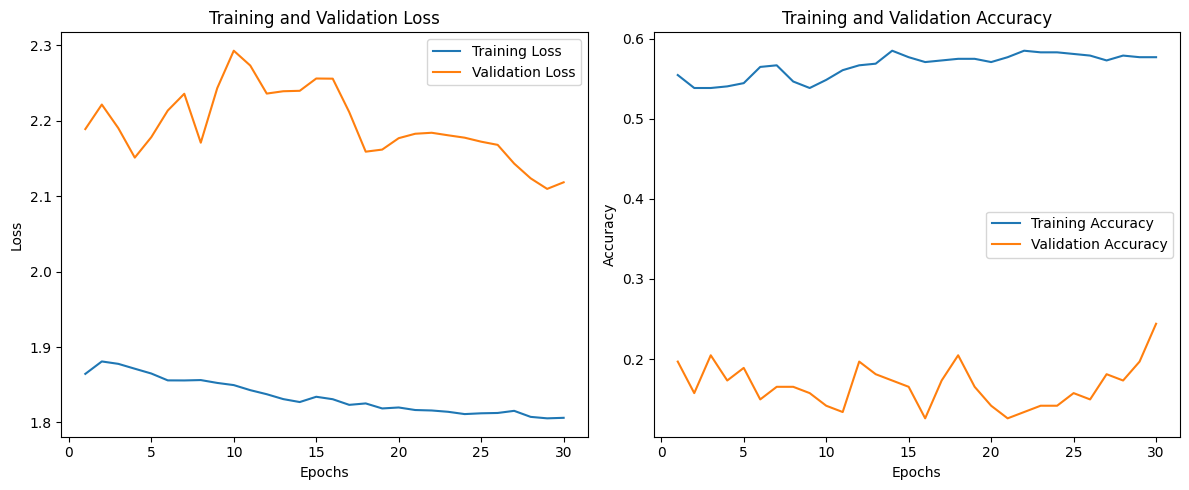

In [ ]:
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_loss = []
        self.val_loss = []
        self.train_accuracy = []
        self.val_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.train_accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

metrics_callback = MetricsCallback()
history = classification_model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[metrics_callback])

epochs = range(1, len(metrics_callback.train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, metrics_callback.train_loss, label='Training Loss')
plt.plot(epochs, metrics_callback.val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, metrics_callback.train_accuracy, label='Training Accuracy')
plt.plot(epochs, metrics_callback.val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()